# Decision Trees
Dataset-> Titanic Survior Prediction Kaggle Challenge

#### Import relevant Libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Preprocess data

In [5]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']

In [6]:
data_clean = data.drop(columns_to_drop, axis=1)

In [7]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


In [9]:
le = LabelEncoder()
data_clean['Sex'] = le.fit_transform(data_clean['Sex'])

In [10]:
data_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [75]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int32(1), int64(4)
memory usage: 45.4 KB


In [74]:
#  Filling Missing values in Age
data_clean = data_clean.fillna(data_clean['Age'].mean())

In [14]:
data_clean.loc[1]

Survived     1.0000
Pclass       1.0000
Sex          0.0000
Age         38.0000
SibSp        1.0000
Parch        0.0000
Fare        71.2833
Name: 1, dtype: float64

In [15]:
input_cols = ['Pclass',"Sex","Age","SibSp","Parch","Fare"]
output_cols = ["Survived"]

X = data_clean[input_cols]
Y = data_clean[output_cols]

print(X.shape,Y.shape)
print(type(X))

(891, 6) (891, 1)
<class 'pandas.core.frame.DataFrame'>


## Define Entropy and Information Gain

In [16]:
def entropy(col):
    counts = np.unique(col, return_counts=True)
    N = float(col.shape[0])
    
    ent = 0.0
    for ix in counts[1]:
        p = ix/N
        ent+= (-1.0*p*np.log2(p))
    return ent

In [17]:
def divide_data(x_data, fkey, fval):
    x_right = pd.DataFrame([], columns=x_data.columns)
    x_left = pd.DataFrame([], columns=x_data.columns)
    
    for ix in range(x_data.shape[0]):
        val = x_data[fkey].loc[ix]
        
        if val > fval:
            x_right = x_right.append(x_data.loc[ix])
        else:
            x_left = x_left.append(x_data.loc[ix])
    return x_left, x_right

In [19]:
def information_gain(x_data, fkey, fval):
    
    left_data,right_data = divide_data(x_data, fkey, fval)
    
    # percentage of total samples on left and right
    l = float(left_data.shape[0])/x_data.shape[0]
    r = float(right_data.shape[0])/x_data.shape[0]
    
    if left_data.shape[0] == 0 or right_data.shape[0] == 0:
        return -1000000 # very low information gain
    
    return entropy(x_data.Survived) - (l*entropy(left_data.Survived) + r*entropy(right_data.Survived))

In [20]:
# testing function
for ix in X.columns:
    print(ix)
    print(information_gain(data_clean, ix, data_clean[ix].mean()))

Pclass
0.07579362743608165
Sex
0.2176601066606142
Age
0.0008836151229467681
SibSp
0.009584541813400071
Parch
0.015380754493137694
Fare
0.042140692838995464


### Decision Tree Class

In [47]:
class DecisionTree:
    
    def __init__(self, depth=0, maxDepth=5):
        self.left = None
        self.right = None
        self.fval = None
        self.fkey = None
        self.depth = depth
        self.maxDepth = maxDepth
        self.target = None
    
    def train(self, X_train):
        features = ['Pclass',"Sex","Age","SibSp","Parch","Fare"]
        info_gains = []
        
        for ix in features:
            info_gains.append(information_gain(X_train, ix, X_train[ix].mean()))
        
        self.fkey = features[np.argmax(info_gains)]
        self.fval = X_train[self.fkey].mean()
        
        print("Splitting Tree on: " + self.fkey)
        
        # Splitting Data
        left_data, right_data = divide_data(X_train, self.fkey, self.fval)
        left_data = left_data.reset_index(drop=True)
        right_data = right_data.reset_index(drop=True)
        
        # Base Cases for recursion
        if left_data.shape[0] == 0 or right_data.shape == 0:
            if X_train.Survived.mean() >= 0.5:
                self.target = "Survived"
            else:
                self.target = "Dead"
            return
        
        if self.depth >= self.maxDepth:
            if X_train.Survived.mean() >= 0.5:
                self.target = "Survived"
            else:
                self.target = "Dead"
            return
        
        # Recursive Calls
        self.left = DecisionTree(depth=self.depth+1, maxDepth=self.maxDepth)
        self.left.train(left_data)
        
        self.right = DecisionTree(depth=self.depth+1, maxDepth=self.maxDepth)
        self.right.train(right_data)
        
        # We can set target at every node
        if X_train.Survived.mean() >= 0.5:
            self.target = "Survived"
        else:
            self.target = "Dead"
        return
    
    def predict(self, test):
        if test[self.fkey] > self.fval:
            # we go to right
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else :
            if self.left is None:
                return self.target
            return self.left.predict(test)

### Train-Test Split

In [80]:
split = int(0.7*X.shape[0])
train_data = data_clean[:split]
test_data = data_clean[split:]
test_data = test_data.reset_index(drop=True)

In [81]:
train_data.shape, test_data.shape

((623, 7), (268, 7))

### Training 

In [50]:
dt = DecisionTree()

In [51]:
dt.train(train_data)

Splitting Tree on: Sex
Splitting Tree on: Pclass
Splitting Tree on: Age
Splitting Tree on: SibSp
Splitting Tree on: Age
Splitting Tree on: Pclass
Splitting Tree on: Age
Splitting Tree on: SibSp
Splitting Tree on: Parch
Splitting Tree on: Pclass
Splitting Tree on: SibSp
Splitting Tree on: Fare
Splitting Tree on: Parch
Splitting Tree on: Age
Splitting Tree on: Pclass
Splitting Tree on: Age
Splitting Tree on: Age
Splitting Tree on: Parch
Splitting Tree on: Age
Splitting Tree on: Age
Splitting Tree on: Age
Splitting Tree on: Fare
Splitting Tree on: Age
Splitting Tree on: SibSp
Splitting Tree on: Fare
Splitting Tree on: Fare
Splitting Tree on: Fare
Splitting Tree on: Parch
Splitting Tree on: SibSp
Splitting Tree on: Fare
Splitting Tree on: Fare
Splitting Tree on: Age
Splitting Tree on: Fare
Splitting Tree on: Parch
Splitting Tree on: Fare
Splitting Tree on: Pclass
Splitting Tree on: Pclass
Splitting Tree on: Fare
Splitting Tree on: Fare
Splitting Tree on: SibSp
Splitting Tree on: Fare
Split

### Predictions

In [53]:
Y_pred = []
for i in range(test_data.shape[0]):
    Y_pred.append(dt.predict(test_data.loc[i]))

In [55]:
print(Y_pred)

['Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Dead', 'Survived', 'Survived', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Survived', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Dead', 'Survived', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Survived', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Survived', 'Survived', 'Survived', 'Dead', 'Dead', 'Dead', 'Survived', 'Dead', 'Survived', 'Survived', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Survived', 'Dead', 'Dead', 'Survived', 'Dead', 'Dead', 'Dead', 'Dead', 'Dead', 'Survived', 'Survived', 'Dead', 'Dead', 'Survived', 'Dead',

In [56]:
Y_actual = test_data[output_cols]

In [58]:
Y_pred = le.fit_transform(Y_pred)
print(Y_pred)

[0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0
 0 0 0 0 0 1 0 0 0]


### Accuracy

In [59]:
Y_pred.shape, Y_actual.shape

((268,), (268, 1))

In [61]:
Y_pred = Y_pred.reshape((-1,1))
Y_pred.shape

(268, 1)

In [62]:
Accuracy = (np.sum(Y_pred == Y_actual)/Y_actual.shape[0])*100

In [63]:
Accuracy

Survived    83.58209
dtype: float64

    Achieved Accuracy is #83%

# Decision Tree Using Sklearn

In [101]:
sk_dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=5)
sk_dt_ent = DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [102]:
sk_dt_gini.fit(train_data[input_cols], train_data[output_cols])
sk_dt_ent.fit(train_data[input_cols], train_data[output_cols])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [103]:
sk_dt_gini.predict(test_data[input_cols])
sk_dt_ent.predict(test_data[input_cols])

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0], dtype=int64)

In [105]:
print("Using GINI as Criteria", sk_dt_gini.score(test_data[input_cols],test_data[output_cols]))
print("Using ENTROPY as Criteria", sk_dt_ent.score(test_data[input_cols],test_data[output_cols]))

Using GINI as Criteria 0.8171641791044776
Using ENTROPY as Criteria 0.8283582089552238


    Accuracy achieved is  82% which is nearly equal to our self implemented DecisionTree Accuracy 

### Using Random Forest

In [107]:
X_train = train_data[input_cols]
Y_train = np.array(train_data[output_cols]).reshape((-1,))
X_test = test_data[input_cols]
Y_test = np.array(test_data[output_cols]).reshape((-1,))

In [108]:
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=5)

In [109]:
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [110]:
rf.score(X_test, Y_test)

0.8432835820895522

    Lets try on Different values of estimators

In [112]:
acc_list = []
for e in range(1, 50):
    acc_list.append(cross_val_score(RandomForestClassifier(n_estimators=e,criterion="entropy",max_depth=5), X_train, Y_train, cv=5).mean())     

In [113]:
acc_list

[0.7944645161290322,
 0.7912774193548386,
 0.8105677419354839,
 0.804116129032258,
 0.8009290322580644,
 0.8058193548387097,
 0.7929161290322579,
 0.8041806451612903,
 0.7977806451612903,
 0.8105290322580645,
 0.8026064516129032,
 0.7945548387096775,
 0.8169677419354839,
 0.8185935483870967,
 0.8025161290322581,
 0.8121290322580645,
 0.8137290322580645,
 0.7976903225806451,
 0.8105806451612902,
 0.8105032258064515,
 0.8105419354838709,
 0.8137935483870968,
 0.8282322580645161,
 0.8121548387096773,
 0.8202064516129033,
 0.8057419354838709,
 0.8217548387096775,
 0.8089419354838709,
 0.8233935483870967,
 0.8153806451612903,
 0.8153806451612903,
 0.8201677419354837,
 0.8153290322580645,
 0.8073419354838709,
 0.8121419354838709,
 0.8233806451612903,
 0.8137548387096775,
 0.8170064516129033,
 0.8249935483870967,
 0.8201548387096775,
 0.8185161290322581,
 0.8089290322580645,
 0.8073548387096775,
 0.816941935483871,
 0.8185548387096773,
 0.8073677419354839,
 0.816941935483871,
 0.8041419354838

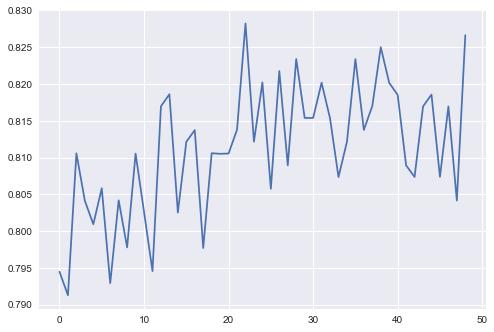

In [114]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.plot(acc_list)
plt.show()

In [116]:
print(acc_list[np.argmax(acc_list)])

0.8282322580645161


    Nearly 83% accuracy 